In [1]:
library(tidyverse)
library(sf)
library(here)
library("rnaturalearth")
library("rnaturalearthdata")

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.0     v dplyr   1.0.5
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Linking to GEOS 3.9.0, GDAL 3.2.1, PROJ 7.2.1

here() starts at C:/Users/Angel/Documents/VIZZUALITY_CHALLENGE



In [2]:
path <- here()
path_data <- file.path(path, "data")


In [3]:
print(path_data)

[1] "C:/Users/Angel/Documents/VIZZUALITY_CHALLENGE/data"


In [4]:
data_csv_list <- list.files(path_data, ".csv", full.names = T) %>% grep("_TA|_TR",., invert = T, value = T)
# data_csv_list

In [5]:
irrig_types <- list("TA" = "all technologies",
                    "TI" = "Irrigated",
                    "TH" = "Rainfed high input",
                    "TL" = "Rainfed low input",
                    "TS" = "Rainfed subsistance",
                    "TR" = "Rainfed total")

In [6]:
t1 <- Sys.time()
for(i in 1:length(data_csv_list)){
  print(basename(data_csv_list[i]))
  df_1 <- read.csv(data_csv_list[i], quote = "")
  
  var_soy <- grep("soyb", names(df_1), value = T)
  
  df_clean <- df_1[, c("x", "y", "rec_type", "tech_type", var_soy,
                       "year_data", "source", "name_cntr", "name_adm1")]
  
  names(df_clean)[names(df_clean) == var_soy] <- "soy_beans"
  
  df_clean <- filter(df_clean, soy_beans > 0)
  
  irrig_code <- str_split(basename(data_csv_list[i]), pattern = "_") %>%
    unlist() %>% gsub(".csv", "", .) %>% tail(., 1)
  df_clean$irrigation <- irrig_types[[irrig_code]]
  
  if(i == 1){
    df_total <- df_clean
  } else {
    df_total <- rbind(df_total, df_clean)
  }
}
Sys.time() - t1
rm(df_clean, var_soy, irrig_code, t1)
gc()

[1] "spam2010V2r0_global_A_TH.csv"
[1] "spam2010V2r0_global_A_TI.csv"
[1] "spam2010V2r0_global_A_TL.csv"
[1] "spam2010V2r0_global_A_TS.csv"


Time difference of 1.000172 mins

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2983554,159.4,5420245,289.5,3049021,162.9
Vcells,64481329,492.0,179103113,1366.5,179035398,1366.0


In [7]:
epsg <-  4326 #WSG 84
df_spatial  <-  st_as_sf(df_total, coords = c('x', 'y'), crs = epsg) %>% select(soy_beans, irrigation)
print(paste0("Data frame has ", nrow(df_spatial), " data points"))
head(as.data.frame(df_spatial))

[1] "Data frame has 548418 data points"


,soy_beans,irrigation,geometry
,<dbl>,<chr>,<POINT [°]>
1,90.0,Rainfed high input,POINT (123.2917 53.54167)
2,55.8,Rainfed high input,POINT (122.2083 53.45833)
3,90.0,Rainfed high input,POINT (122.2917 53.45833)
4,90.0,Rainfed high input,POINT (122.375 53.45833)
5,90.0,Rainfed high input,POINT (123.0417 53.45833)
6,90.0,Rainfed high input,POINT (123.125 53.45833)


In [8]:
interest_areas <- st_read(file.path(path_data, "areas.geojson"))
area_asia <- st_cast(interest_areas$geometry[1], "POLYGON")
area_america <- st_cast(interest_areas$geometry[2], "POLYGON")


Reading layer `areas' from data source `C:\Users\Angel\Documents\VIZZUALITY_CHALLENGE\data\areas.geojson' using driver `GeoJSON'
Simple feature collection with 2 features and 0 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -68.20312 ymin: -28.92163 xmax: 88.94531 ymax: 30.44867
Geodetic CRS:  WGS 84


In [9]:
df_asia <- df_spatial[area_asia,]
df_america <- df_spatial[area_america,]


although coordinates are longitude/latitude, st_intersects assumes that they are planar

although coordinates are longitude/latitude, st_intersects assumes that they are planar

although coordinates are longitude/latitude, st_intersects assumes that they are planar

although coordinates are longitude/latitude, st_intersects assumes that they are planar



In [10]:
print(paste0("Asia's area of interest has ", nrow(df_asia), " data points"))
print(paste0("South America's area of interest has ", nrow(df_america), " data points"))

[1] "Asia's area of interest has 33769 data points"
[1] "South America's area of interest has 37376 data points"


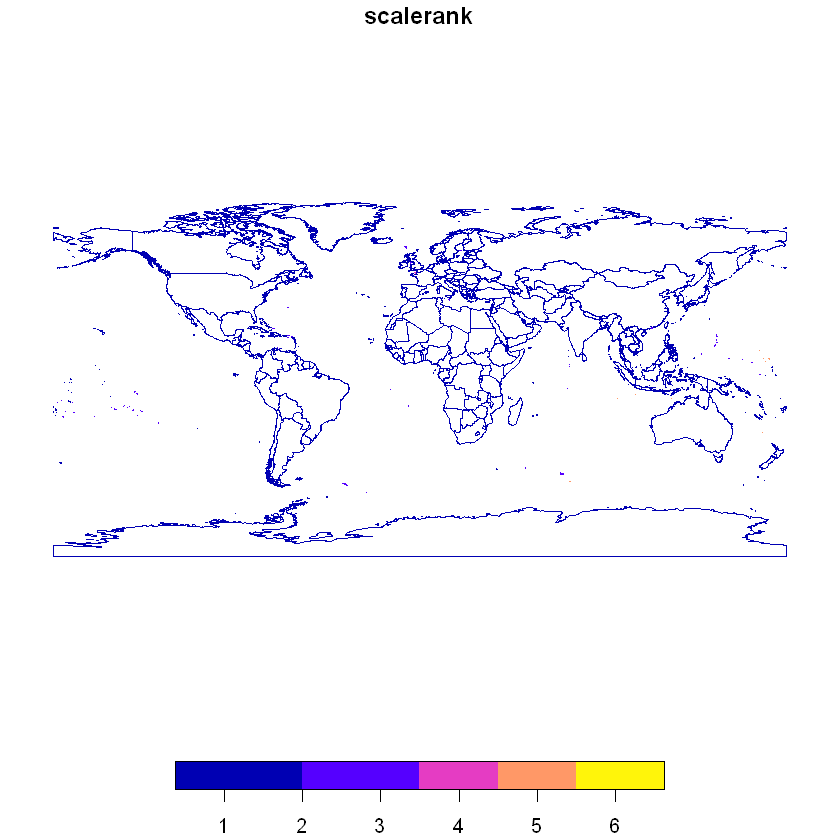

In [11]:
global_map <- ne_countries(scale = 50, returnclass = "sf") %>% st_cast("MULTILINESTRING")
global_map <- global_map[1]
plot(global_map)

although coordinates are longitude/latitude, st_intersection assumes that they are planar

Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"
although coordinates are longitude/latitude, st_intersection assumes that they are planar

Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"


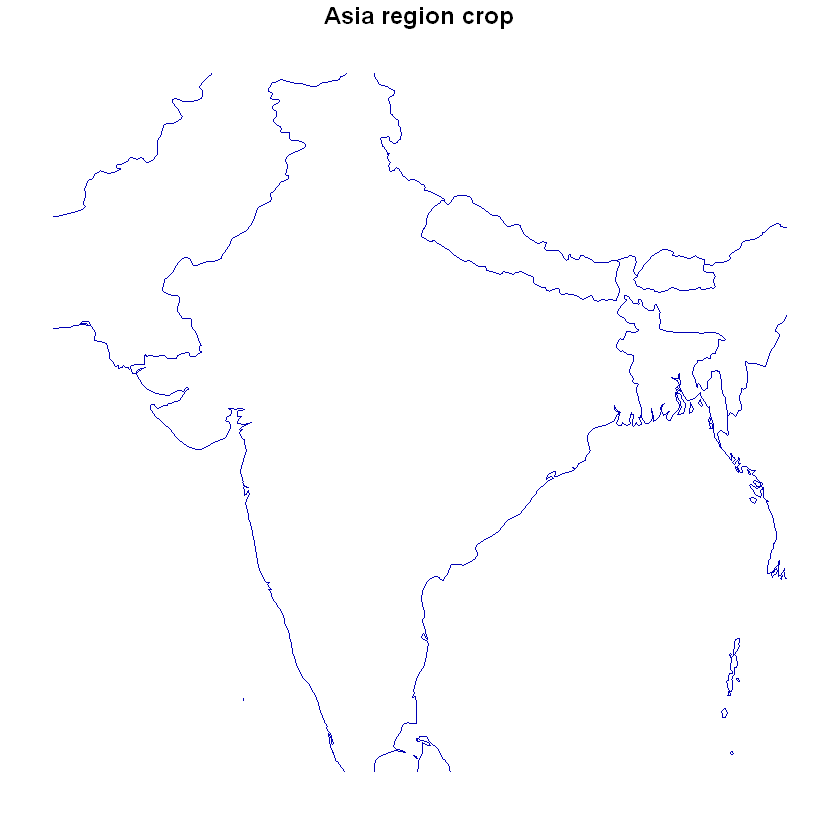

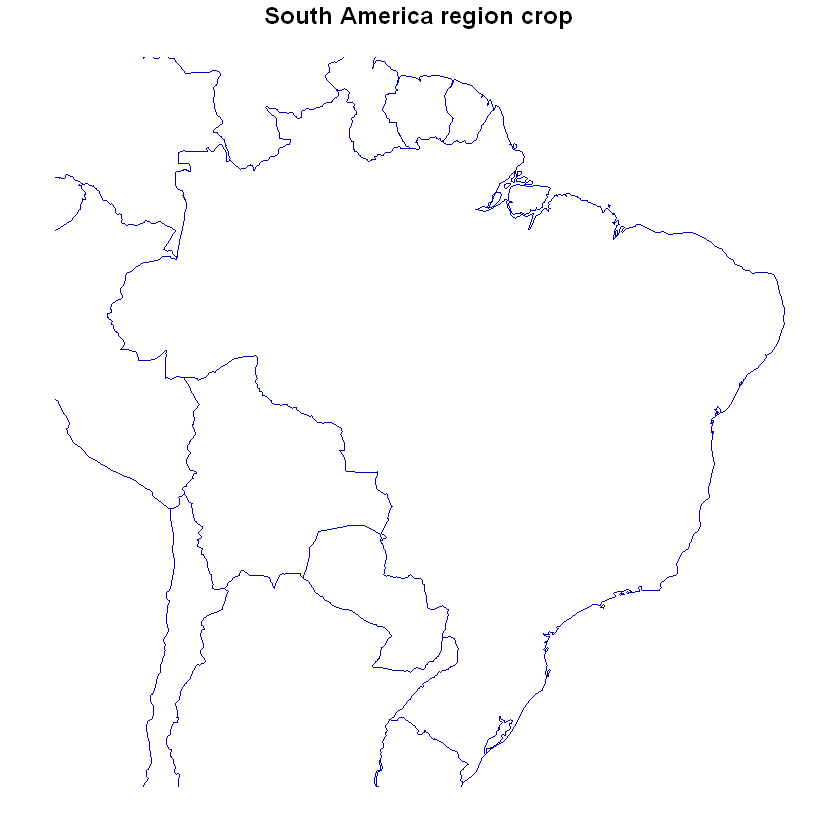

In [12]:
asia_map <- st_crop(global_map, xmin = 65, xmax = 95, ymin = 8.5, ymax = 35)
america_map <- st_crop(global_map, xmin = -77, xmax = -34, ymin = -34, ymax = 7) 


plot(asia_map, main="Asia region crop")
plot(america_map, main="South America region crop")



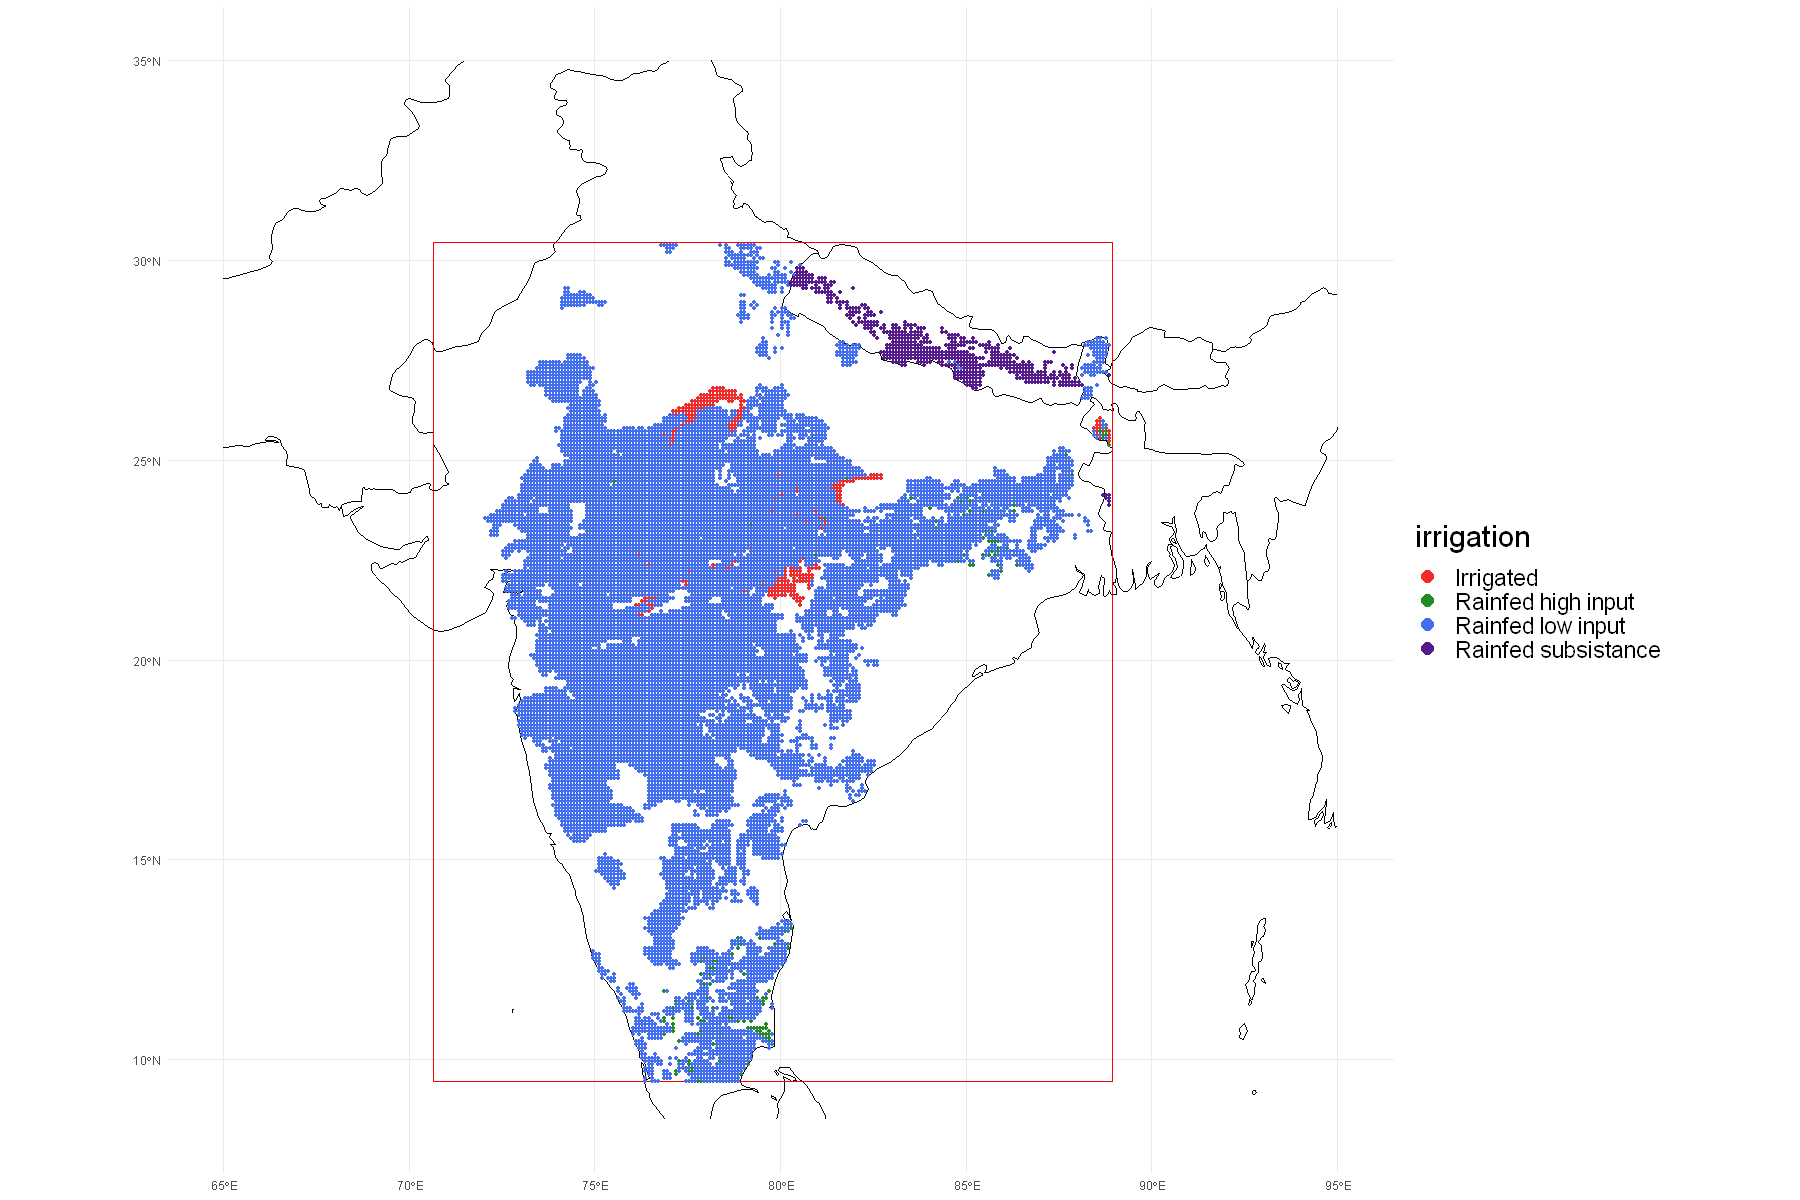

In [74]:
options(repr.plot.width = 18, repr.plot.height = 12, repr.plot.res = 100)
ggplot()+
  geom_sf(data = asia_map, fill = "white") +
  geom_sf(data = area_asia,color = "red", fill = NA)+
  geom_sf(data = df_asia, aes(color=irrigation), size = 1)+
  scale_color_manual(values = c("Irrigated"="firebrick2",
                                "Rainfed high input" = "forestgreen",
                                "Rainfed low input" = "royalblue2",
                                "Rainfed subsistance" = "purple4"))+
  guides(color = guide_legend(override.aes = list(size = rel(4))))+
  theme_minimal()+
  theme(legend.title=element_text(size=rel(2)), 
        legend.text=element_text(size=rel(1.5)))

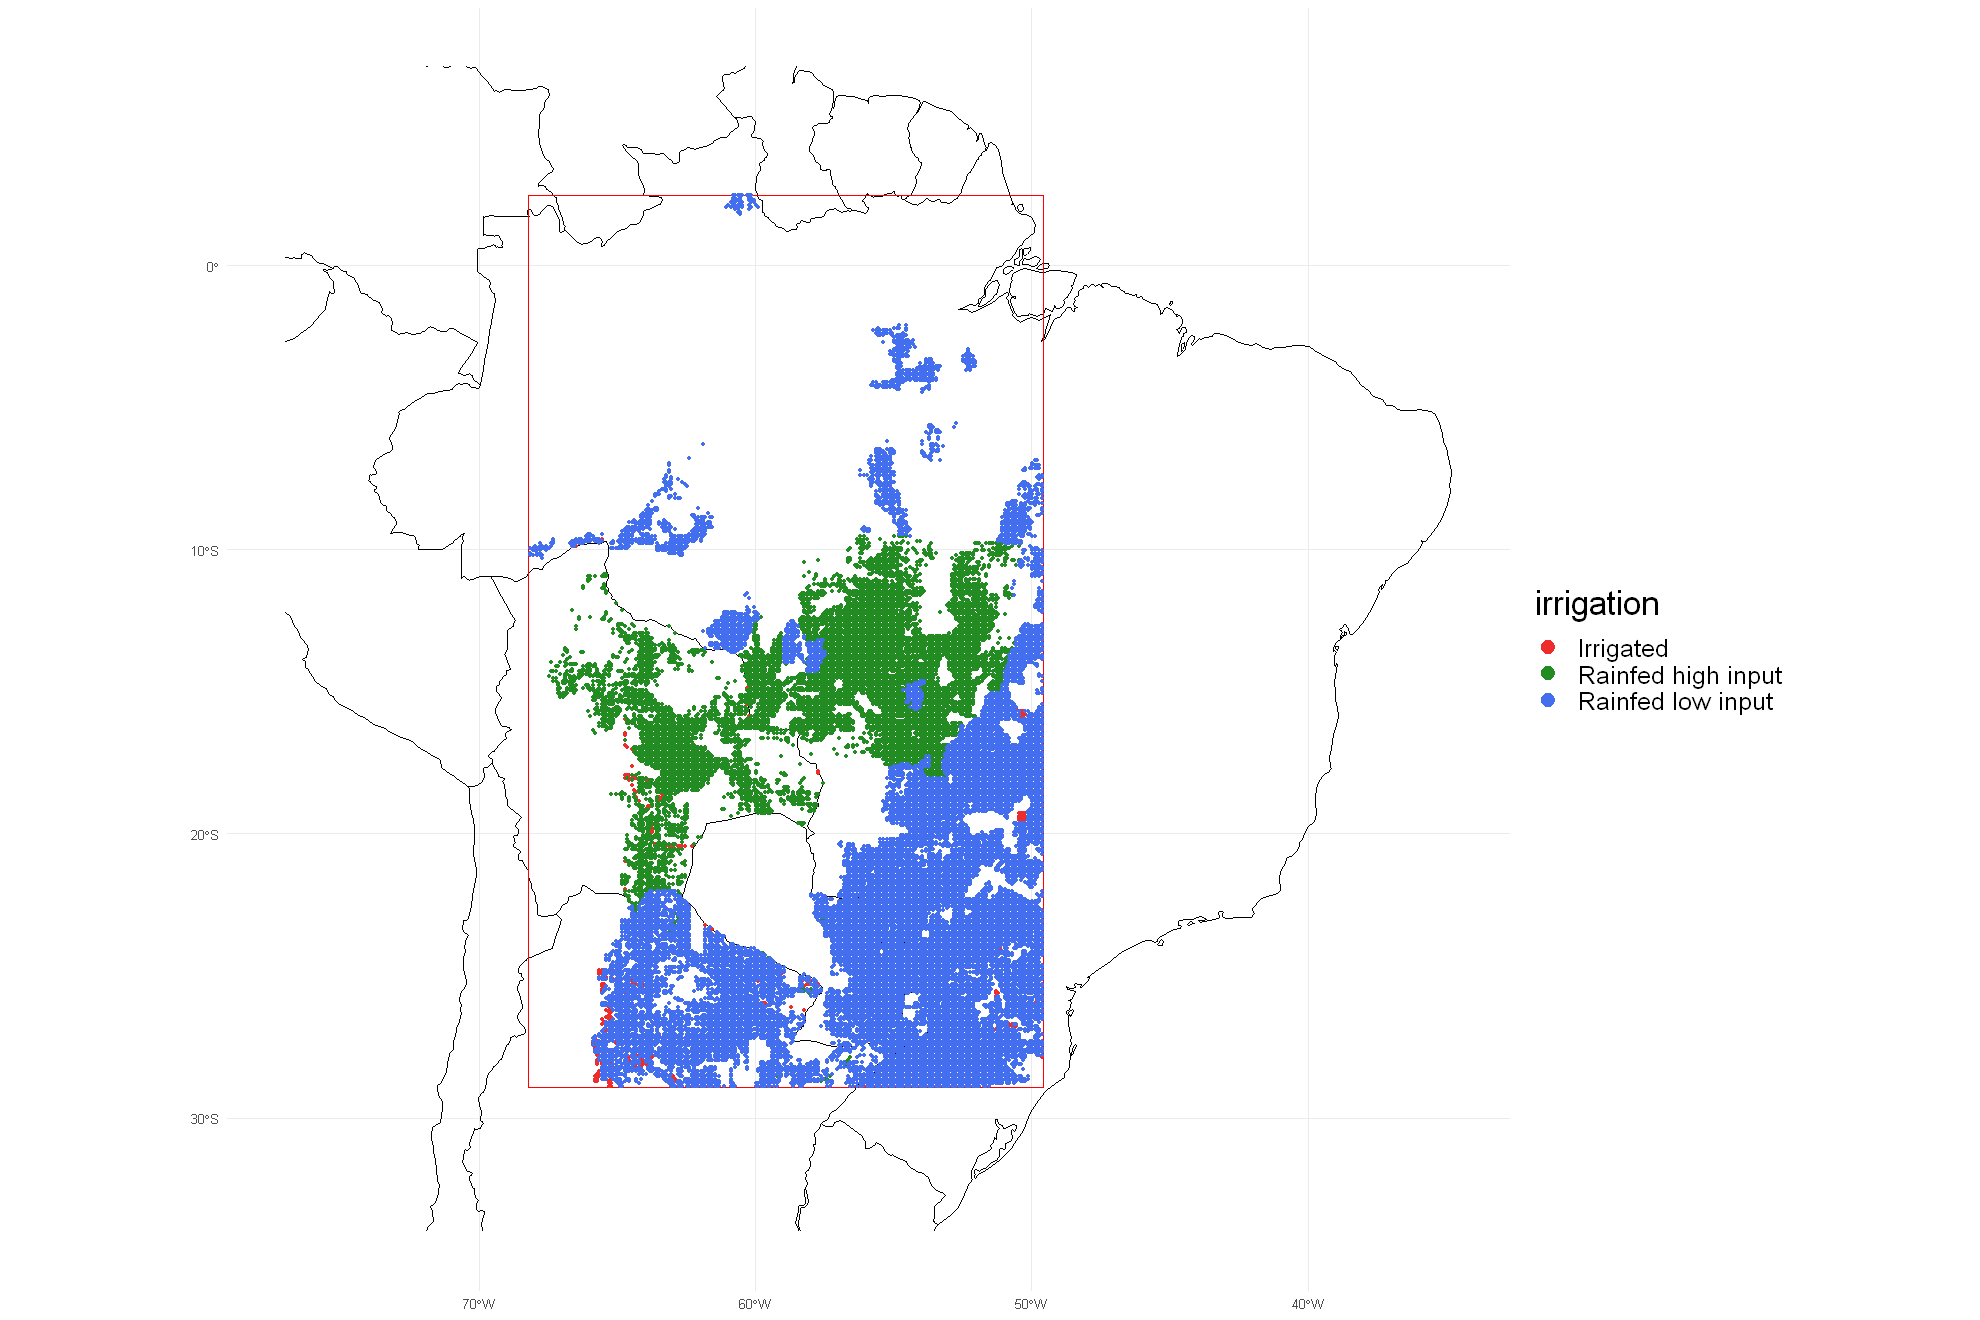

In [77]:
options(repr.plot.width = 18, repr.plot.height = 12, repr.plot.res = 110)
ggplot()+
  geom_sf(data = america_map, fill = "white") +
  geom_sf(data = area_america,color = "red", fill = NA)+
  geom_sf(data = df_america, aes(color=irrigation), size = 1)+
  scale_color_manual(values = c("Irrigated"="firebrick2",
                                "Rainfed high input" = "forestgreen",
                                "Rainfed low input" = "royalblue2",
                                "Rainfed subsistance" = "purple4"))+
  guides(color = guide_legend(override.aes = list(size = rel(4))))+
  theme_minimal()+
  theme(legend.title=element_text(size=rel(2)), 
        legend.text=element_text(size=rel(1.5)))

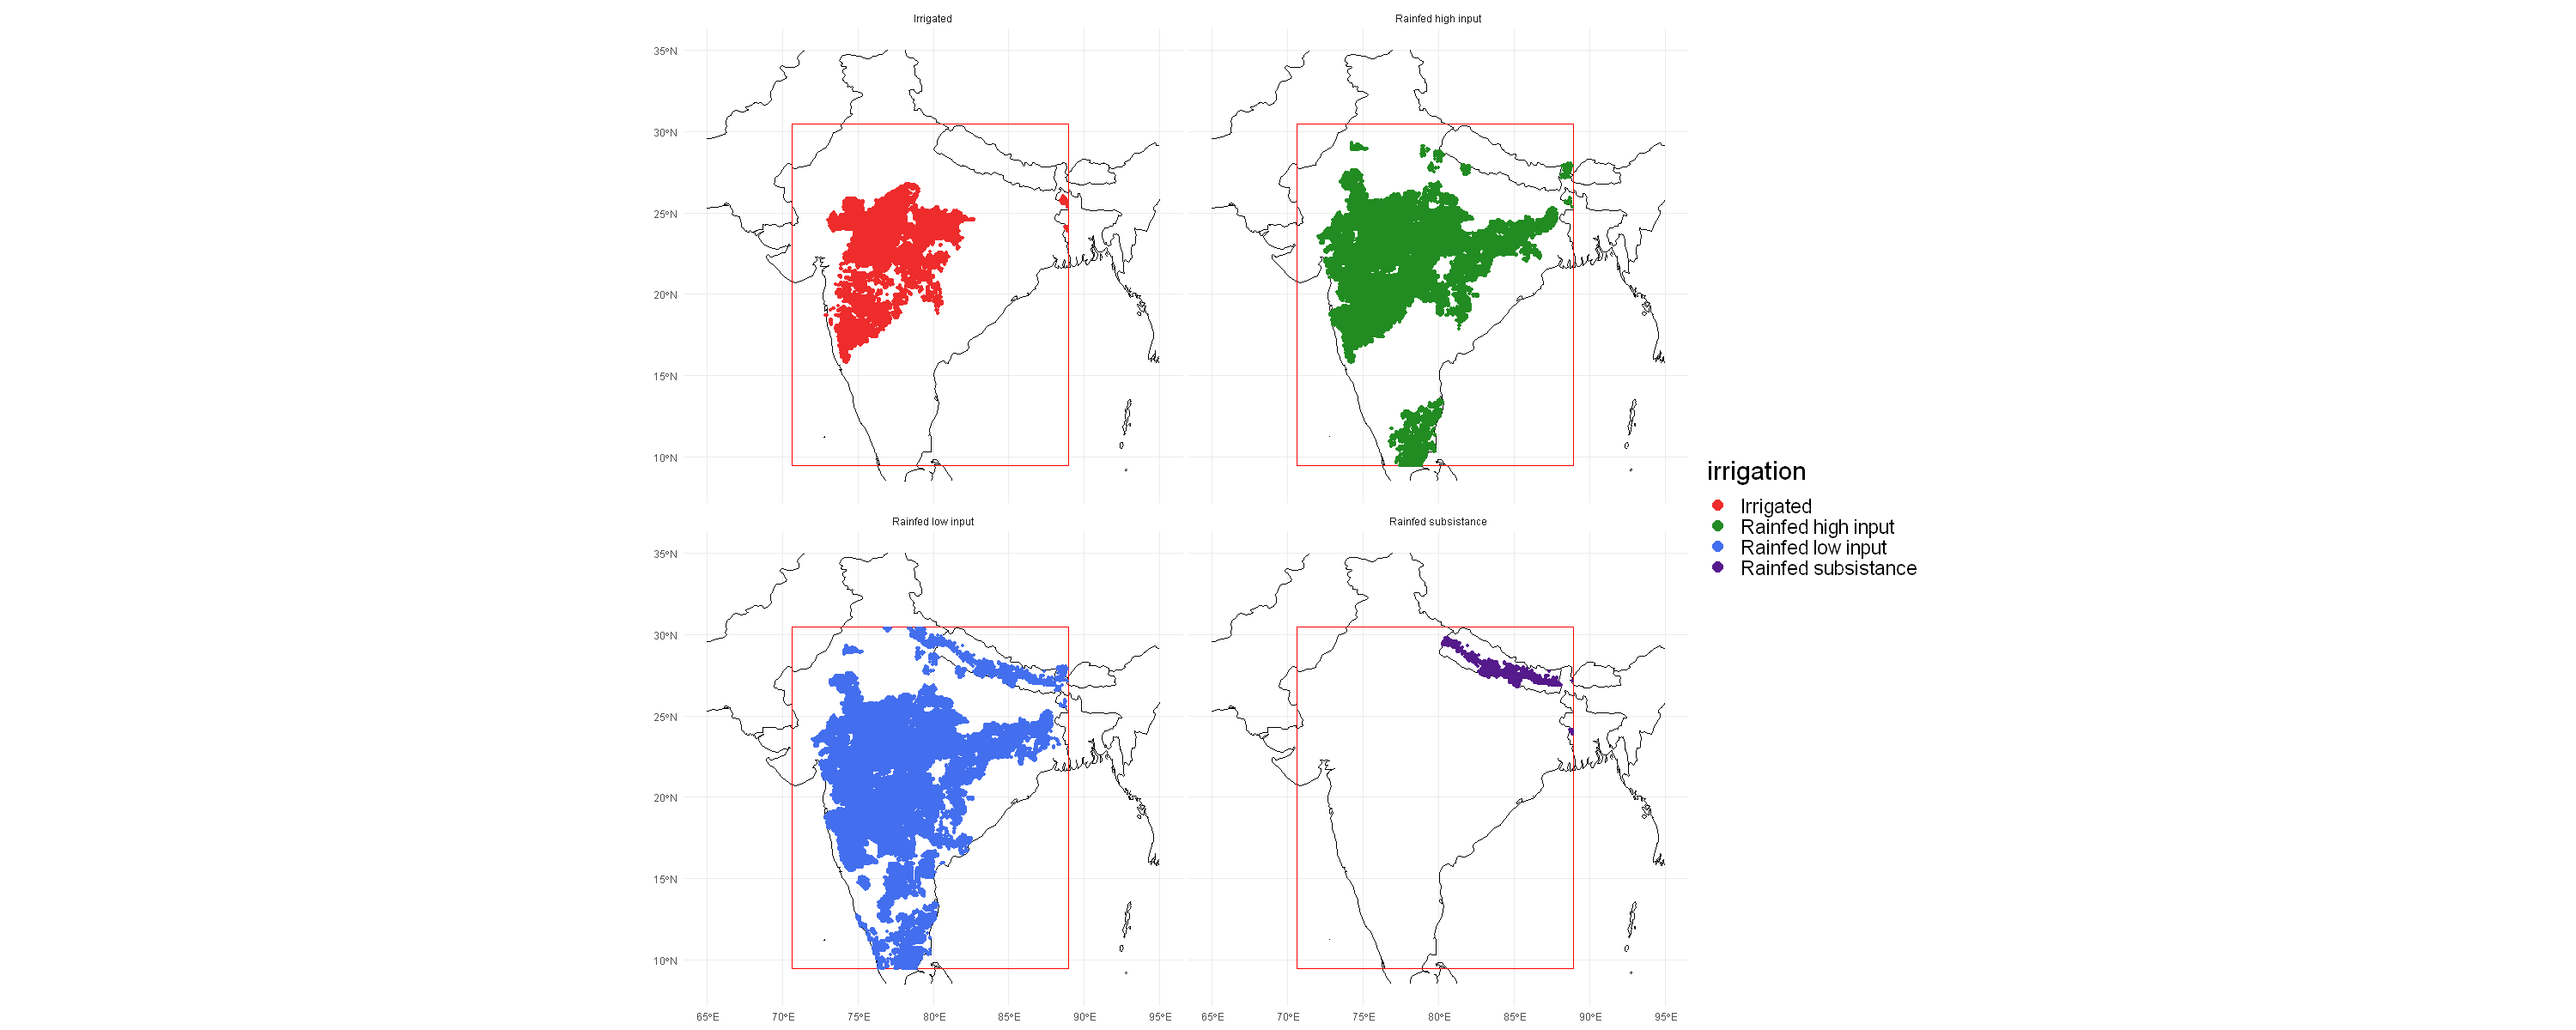

In [81]:
options(repr.plot.width = 30, repr.plot.height = 12, repr.plot.res = 100)
ggplot()+
  geom_sf(data = asia_map, fill = "white") +
  geom_sf(data = area_asia,color = "red", fill = NA)+
  geom_sf(data = df_asia, aes(color=irrigation), size = 1)+
  scale_color_manual(values = c("Irrigated"="firebrick2",
                                "Rainfed high input" = "forestgreen",
                                "Rainfed low input" = "royalblue2",
                                "Rainfed subsistance" = "purple4"))+
  guides(color = guide_legend(override.aes = list(size = rel(4))))+
  theme_minimal()+
  theme(legend.title=element_text(size=rel(2)), 
        legend.text=element_text(size=rel(1.5)))+
  facet_wrap(~irrigation)

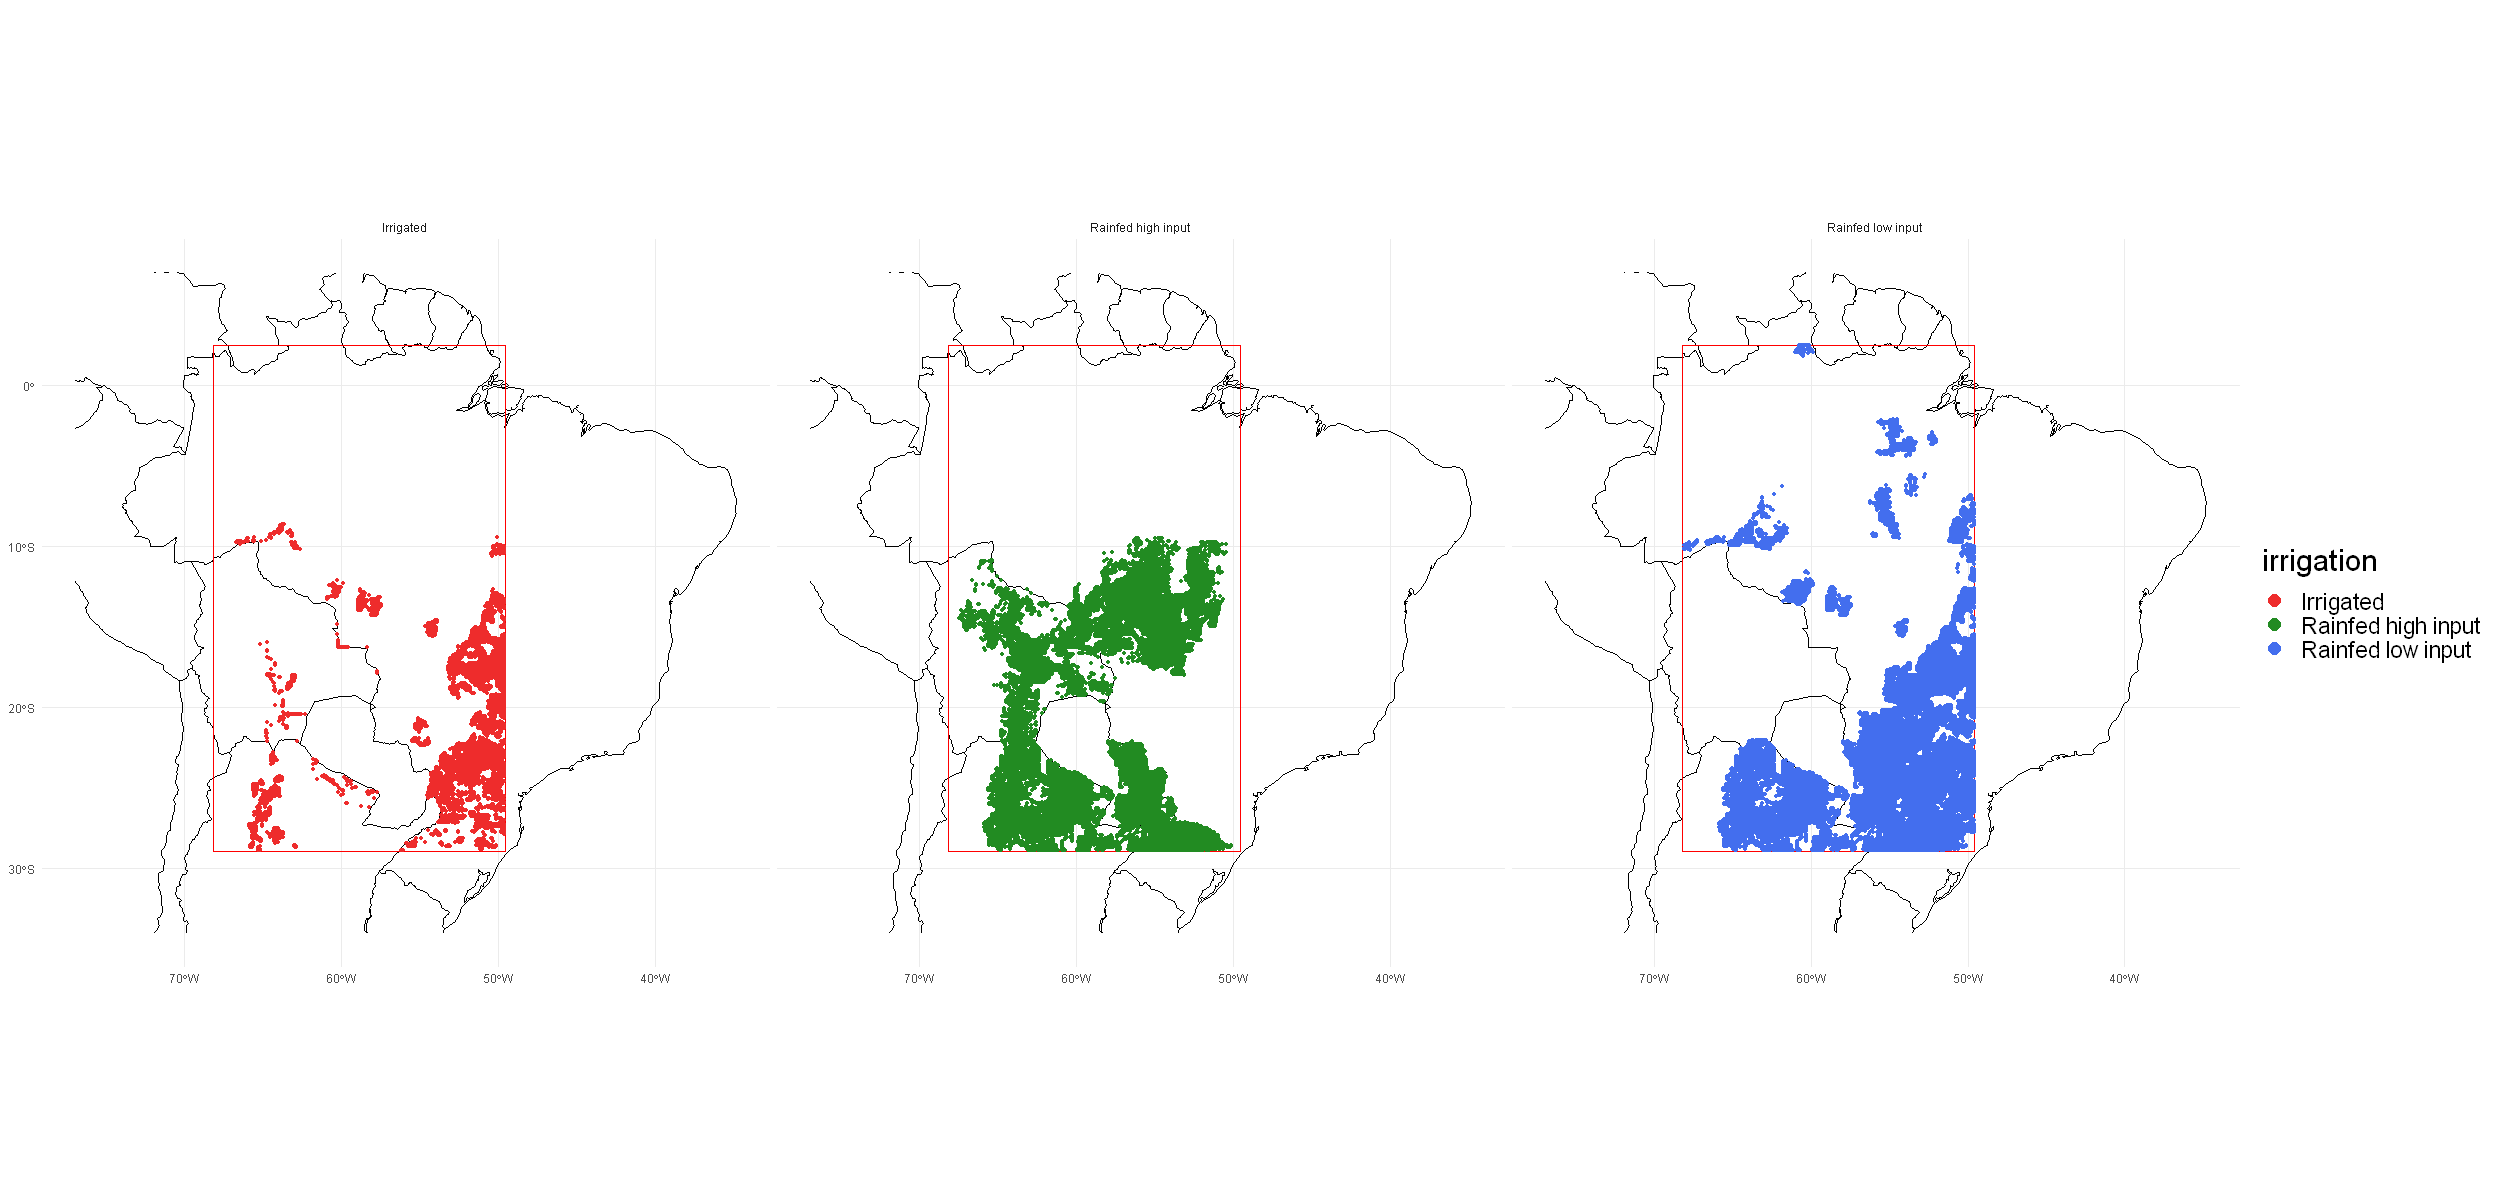

In [86]:
options(repr.plot.width = 25, repr.plot.height = 12, repr.plot.res = 100)
ggplot()+
  geom_sf(data = america_map, fill = "white") +
  geom_sf(data = area_america,color = "red", fill = NA)+
  geom_sf(data = df_america, aes(color=irrigation), size = 1)+
  scale_color_manual(values = c("Irrigated"="firebrick2",
                                "Rainfed high input" = "forestgreen",
                                "Rainfed low input" = "royalblue2",
                                "Rainfed subsistance" = "purple4"))+
  guides(color = guide_legend(override.aes = list(size = rel(4))))+
  theme_minimal()+
  theme(plot.tag = element_text(size=rel(2)),
        legend.title=element_text(size=rel(2)), 
        legend.text=element_text(size=rel(1.5)))+
  facet_wrap(~irrigation)

In [95]:
df_am <- as.data.frame(df_america) %>% mutate("Region" = "S.America")
df_as <- as.data.frame(df_asia) %>% mutate("Region" = "Asia")

df_g1 <- group_by(df_as, Region, irrigation) %>% summarise("Total area (ha)" = sum(soy_beans),
                                                            "Percentage area" = paste0(round((sum(soy_beans)/sum(df_as$soy_beans))*100, 2), "%"),
                                                            "Percentage pixels" = paste0(round(n()/nrow(df_as)*100, 2), "%"),
                                                            "Median area (ha) per pixel" = median(soy_beans))

df_g2 <- group_by(df_am, Region, irrigation) %>% summarise("Total area (ha)" = sum(soy_beans),
                                                            "Percentage area" = paste0(round((sum(soy_beans)/sum(df_am$soy_beans))*100, 2), "%"),
                                                            "Percentage pixels" = paste0(round(n()/nrow(df_am)*100, 2), "%"),
                                                            "Median area (ha) per pixel" = median(soy_beans))
df_group <- rbind(df_g1, df_g2)
df_group

`summarise()` has grouped output by 'Region'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Region'. You can override using the `.groups` argument.



Region,irrigation,Total area (ha),Percentage area,Percentage pixels,Median area (ha) per pixel
<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Asia,Irrigated,56867.3,0.66%,17.53%,5.6
Asia,Rainfed high input,4853608.1,55.94%,35.24%,37.2
Asia,Rainfed low input,3763800.4,43.38%,45.49%,26.5
Asia,Rainfed subsistance,2563.8,0.03%,1.74%,0.5
S.America,Irrigated,51139.2,0.22%,13.23%,1.0
S.America,Rainfed high input,11517880.1,50.34%,41.63%,197.1
S.America,Rainfed low input,11309608.1,49.43%,45.13%,113.5


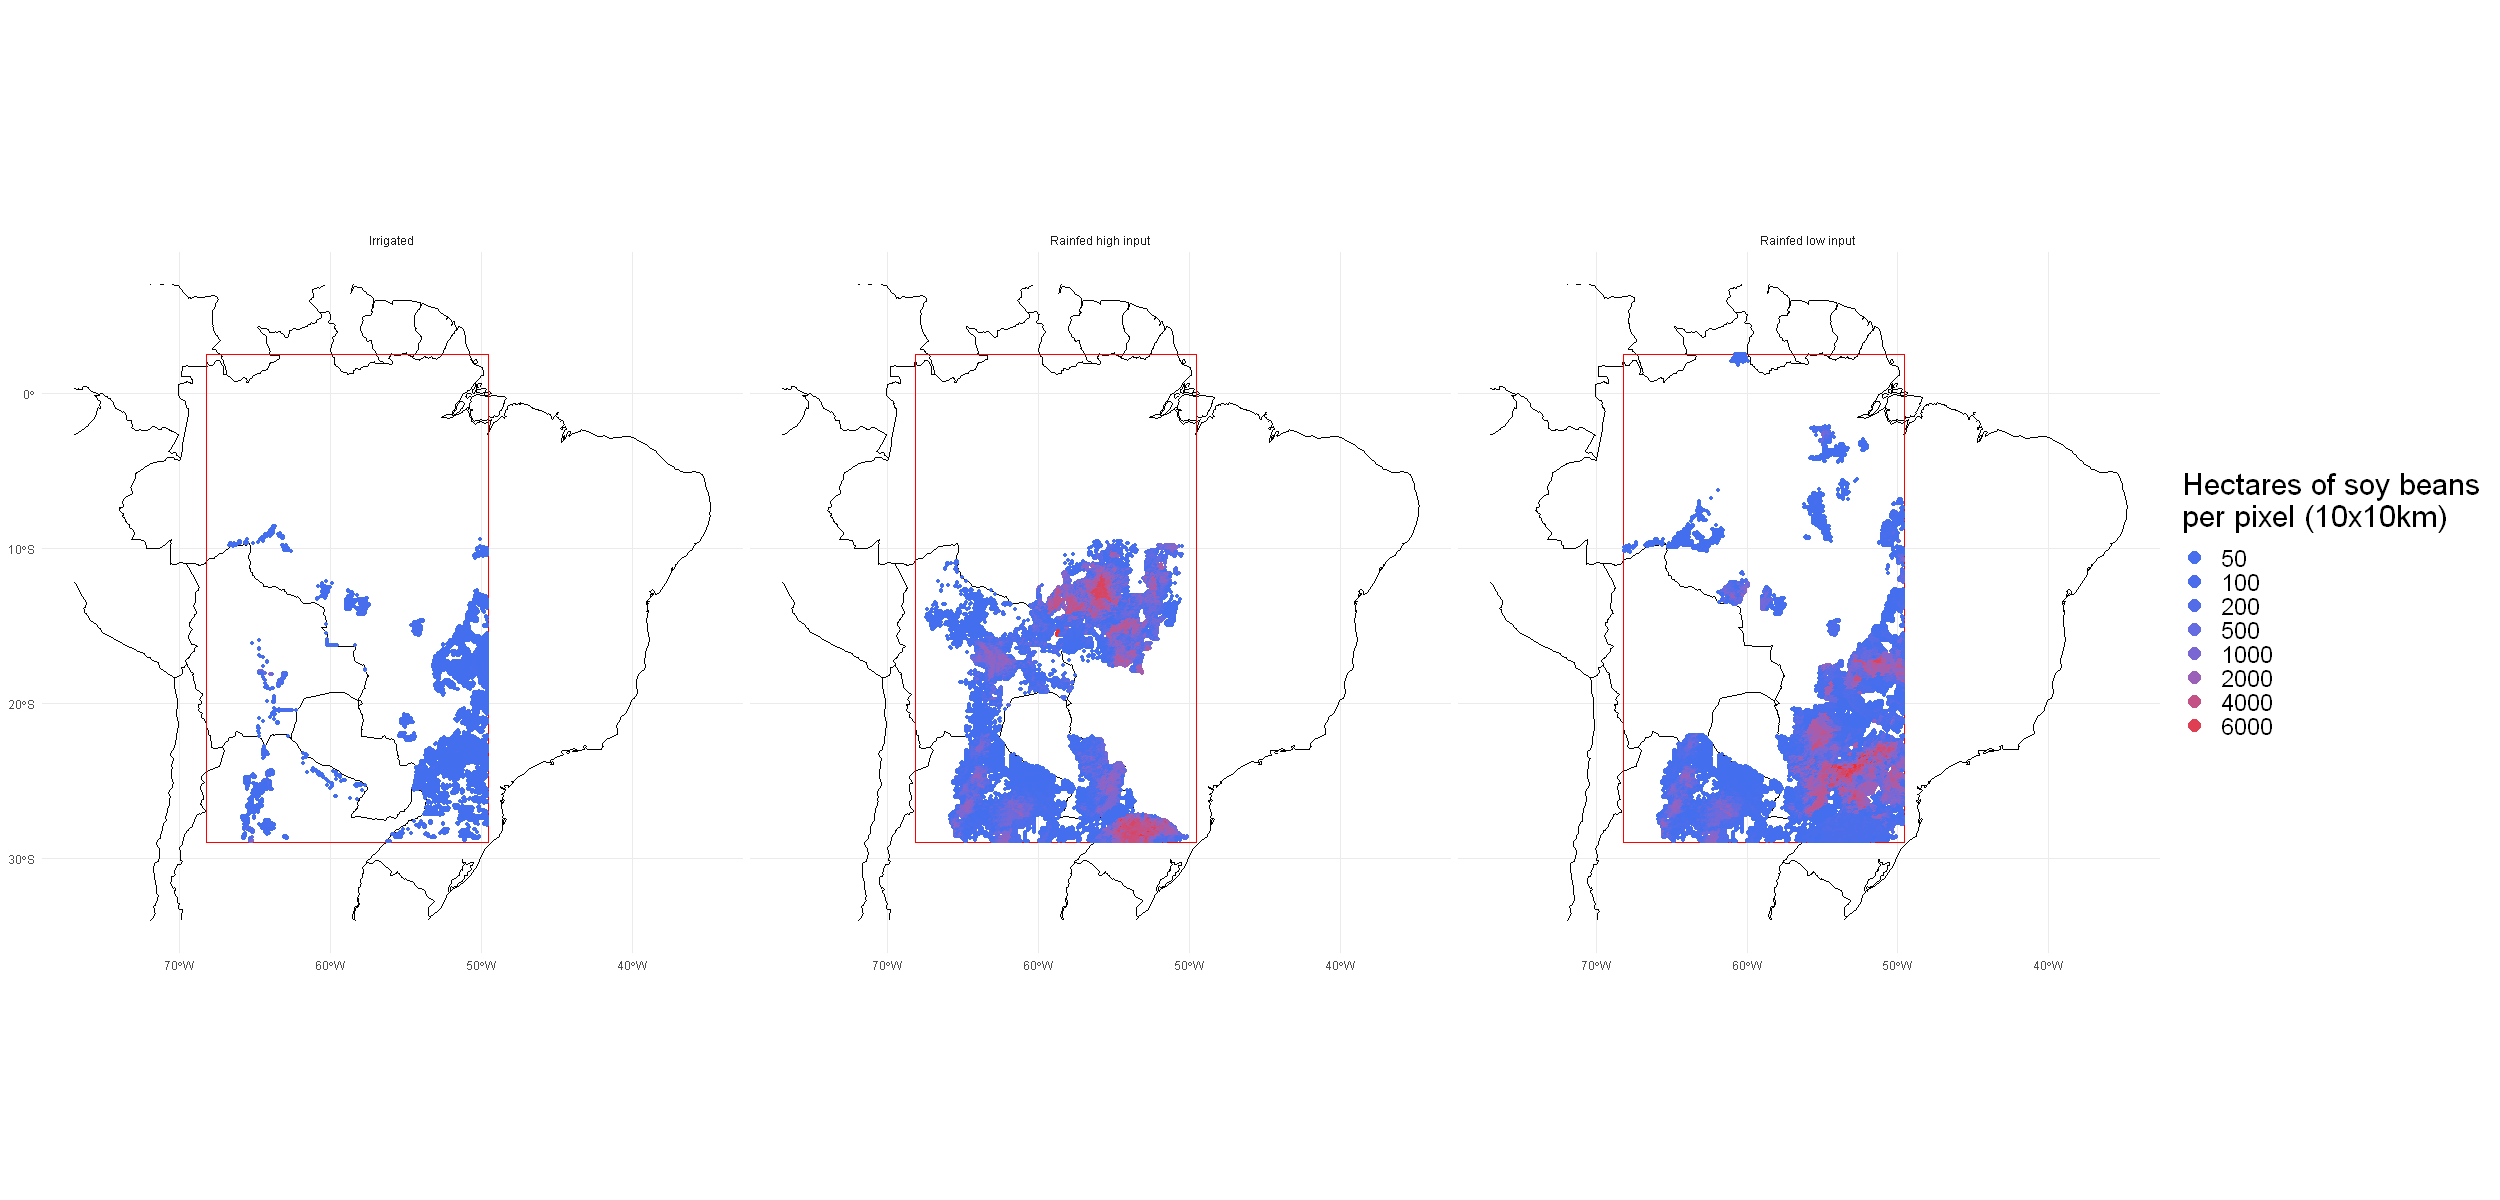

In [104]:
options(repr.plot.width = 25, repr.plot.height = 12, repr.plot.res = 100)
ggplot()+
  geom_sf(data = america_map, fill = "white") +
  geom_sf(data = area_america,color = "red", fill = NA)+
  geom_sf(data = df_america, aes(color=soy_beans), size = 1)+
  scale_color_gradient(low="royalblue2", high="firebrick2", breaks = c(50, 100, 200, 500, 1000, 2000, 4000, 6000))+
  guides(color = guide_legend(override.aes = list(size = rel(4))))+
  theme_minimal()+
  labs(color = "Hectares of soy beans\nper pixel (10x10km)")+
  theme(plot.tag = element_text(size=rel(2)),
        legend.title=element_text(size=rel(2)), 
        legend.text=element_text(size=rel(1.5)))+
  facet_wrap(~irrigation)

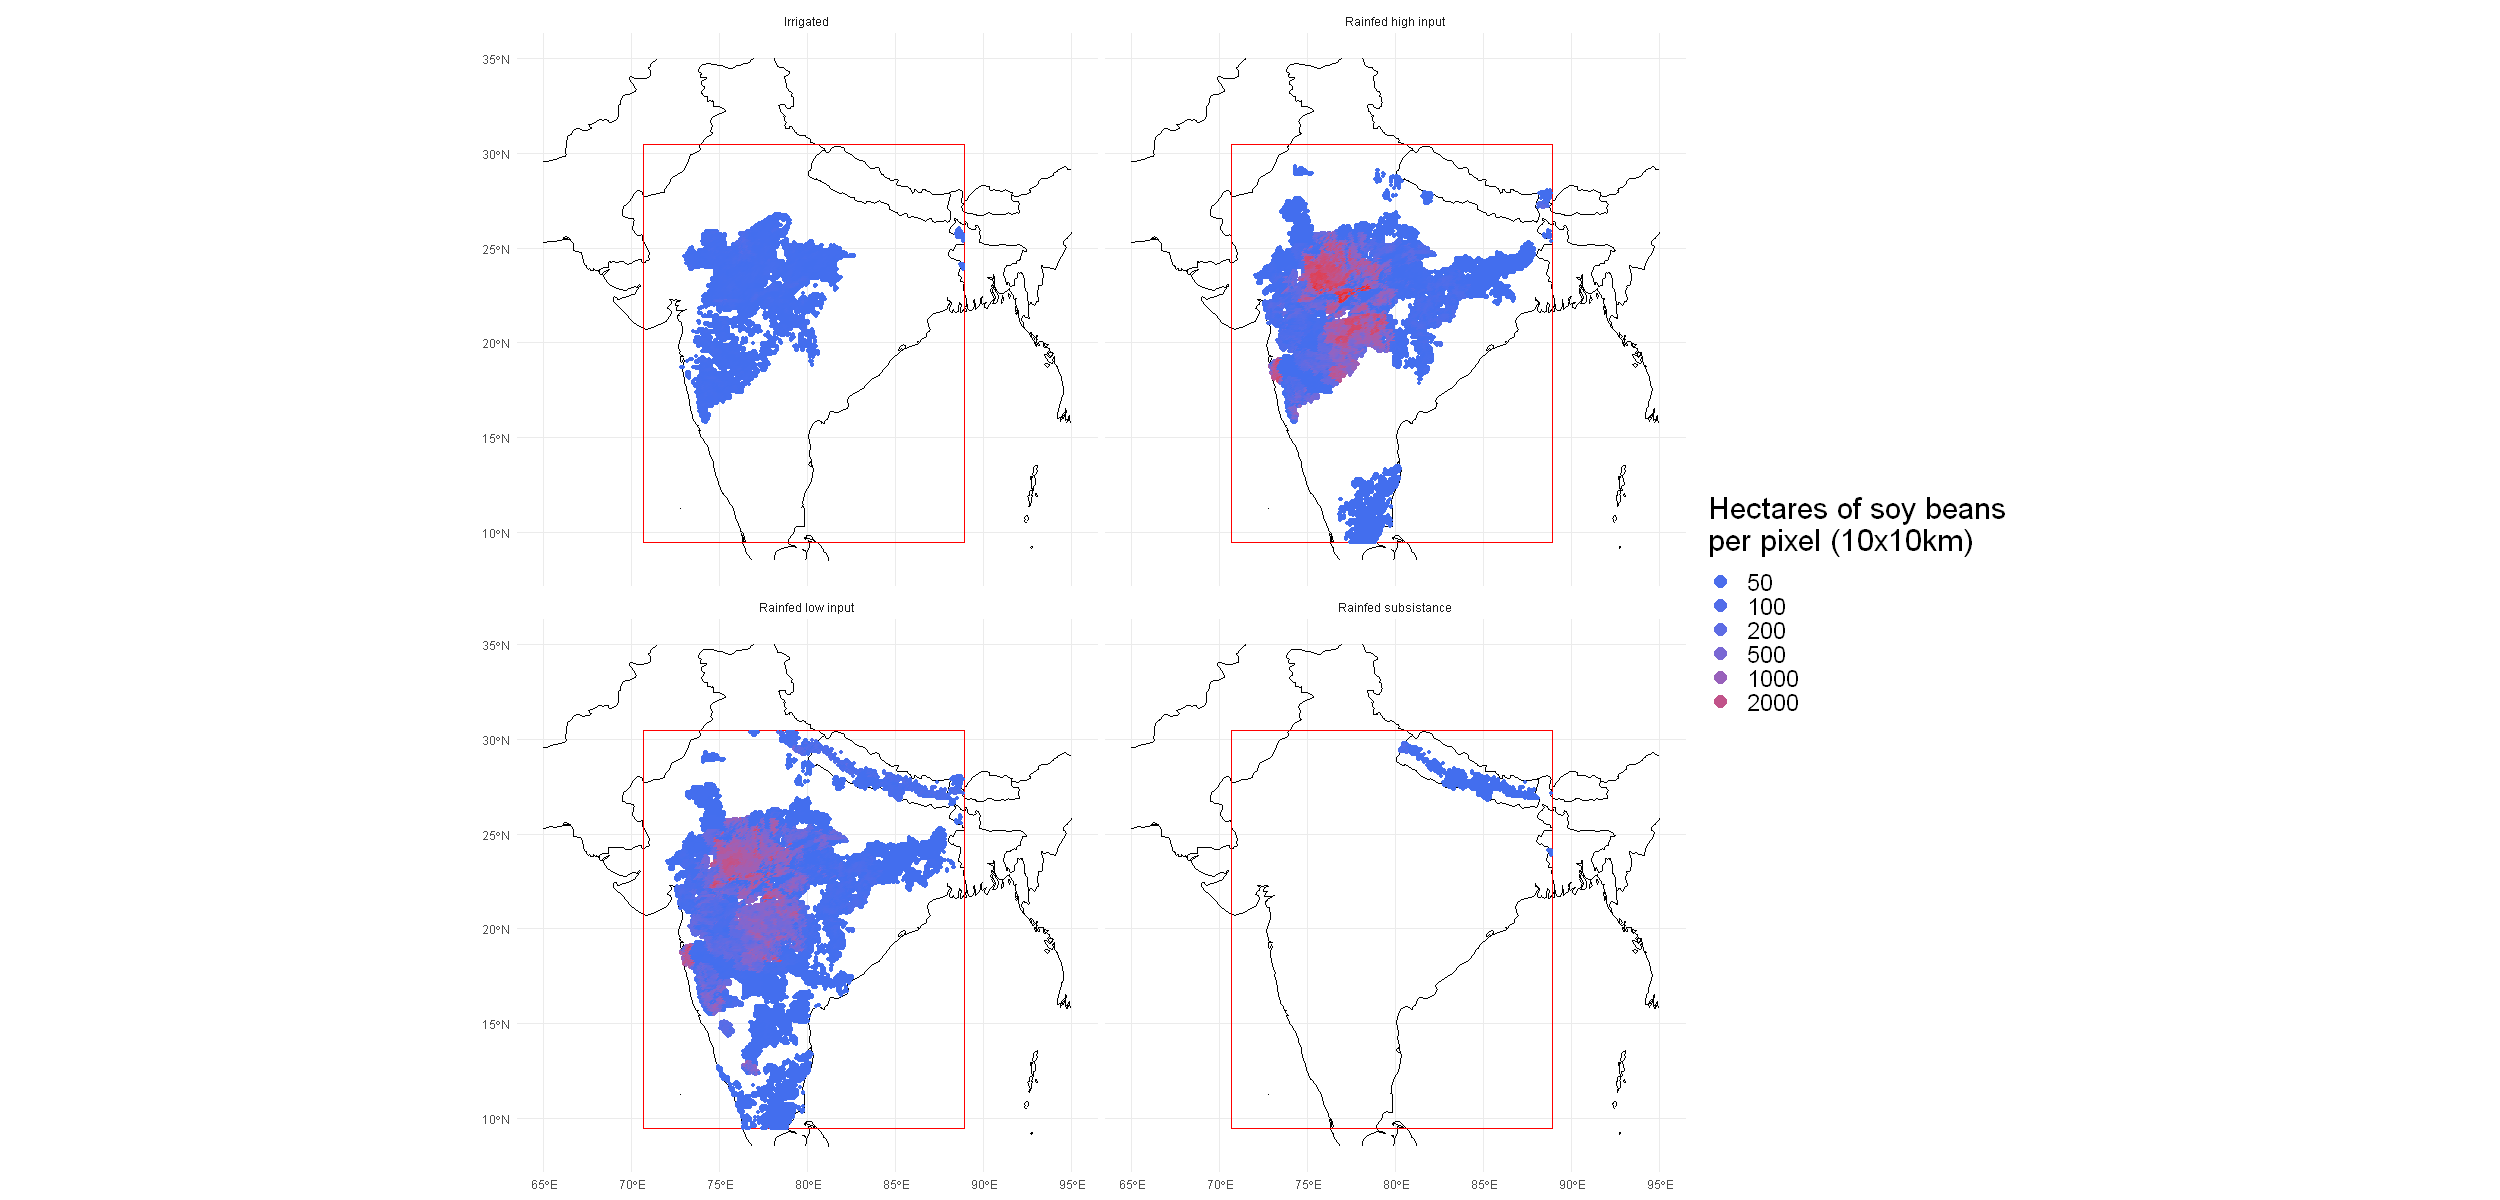

In [106]:
options(repr.plot.width = 25, repr.plot.height = 12, repr.plot.res = 100)
ggplot()+
  geom_sf(data = asia_map, fill = "white") +
  geom_sf(data = area_asia,color = "red", fill = NA)+
  geom_sf(data = df_asia, aes(color=soy_beans), size = 1)+
  scale_color_gradient(low="royalblue2", high="firebrick2", breaks = c(50, 100, 200, 500, 1000, 2000, 4000, 6000))+
  guides(color = guide_legend(override.aes = list(size = rel(4))))+
  theme_minimal()+
  labs(color = "Hectares of soy beans\nper pixel (10x10km)")+
  theme(plot.tag = element_text(size=rel(2)),
        legend.title=element_text(size=rel(2)), 
        legend.text=element_text(size=rel(1.5)))+
  facet_wrap(~irrigation)